# Cifar5 experiments

Experiments:
- L2 vs EDL (probability vs entropy)
- Accuracy vs uncertainty threshold

In [1]:
import os
import os.path as osp
import sys
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import torch

from mmengine import Config
from mmengine.runner import Runner

from mmpretrain.apis import get_model
from mmpretrain.registry import DATASETS
from mmpretrain.structures import DataSample

In [2]:
# include parent path
sys.path.append(os.path.abspath('..'))

In [4]:
# baseline cfg
baseline_cfg = Config.fromfile('../configs/edl_cifar5/default_resnet18_cifar5.py')
baseline_ckpt = '../work_dirs/default_resnet18_cifar5/epoch_50.pth'
assert osp.exists(baseline_ckpt)
baseline_cfg.load_from = baseline_ckpt
baseline_cfg.work_dir = '../work_dirs/default_resnet18_cifar5/notebook_test'

# evidence deep learning cfg
edl_cfg = Config.fromfile('../configs/edl_cifar5/edl-sse-softplus_resnet18_cifar5.py')
edl_ckpt = '../work_dirs/edl-sse-softplus_resnet18_cifar5/epoch_50.pth'
assert osp.exists(edl_ckpt)
edl_cfg.load_from = edl_ckpt
edl_cfg.work_dir = '../work_dirs/edl-sse-softplus_resnet18_cifar5/notebook_test'

# add data prefix
baseline_cfg.test_dataloader.dataset.data_root = osp.join(
    '../',
    baseline_cfg.test_dataloader.dataset.data_root
)

edl_cfg.test_dataloader.dataset.data_root = osp.join(
    '../',
    edl_cfg.test_dataloader.dataset.data_root
)

Try to run the validation loop here using custom functions

# Accuracy vs Uncertainty


06/07 06:17:14 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.9 (main, Apr 17 2024, 14:40:35) [GCC 9.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 3407
    GPU 0: NVIDIA GeForce RTX 3090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.7, V11.7.99
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 1.13.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arc

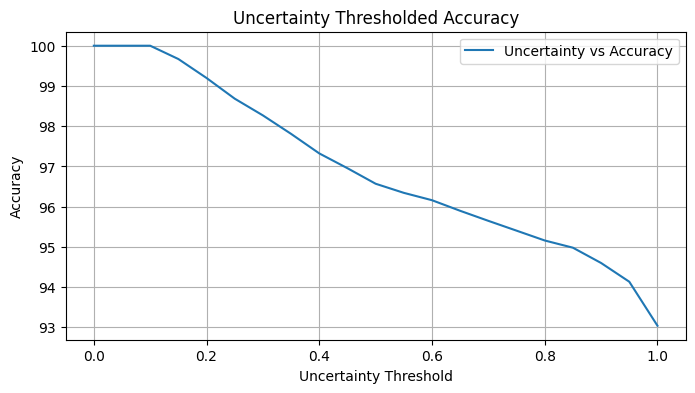

In [5]:
# plot Accuracy vs Uncertainty Plot
edl_cfg.test_evaluator.type = "UncertaintyThresholdedAccuracy"

# run EDL
runner = Runner.from_cfg(edl_cfg)
metrics = runner.test()
edl_ret = metrics['uncert_thresh_acc/metric']

# assume that there are 20 + 1 bins
num_bins = 21
x = np.linspace(0, 1, num_bins)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(x, edl_ret, label='Uncertainty vs Accuracy')
plt.xlabel('Uncertainty Threshold')
plt.ylabel('Accuracy')
plt.title('Uncertainty Thresholded Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# change evaluation metric
baseline_cfg.test_evaluator.type = "PredictiveDistributionECDF"
edl_cfg.test_evaluator.type = "PredictiveDistributionECDF"

# replace the dataset with the last 5 categories
baseline_cfg.test_dataloader.dataset['use_unseen_classes'] = True
edl_cfg.test_dataloader.dataset['use_unseen_classes'] = True

06/07 06:18:23 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.9 (main, Apr 17 2024, 14:40:35) [GCC 9.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 3407
    GPU 0: NVIDIA GeForce RTX 3090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.7, V11.7.99
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 1.13.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arc

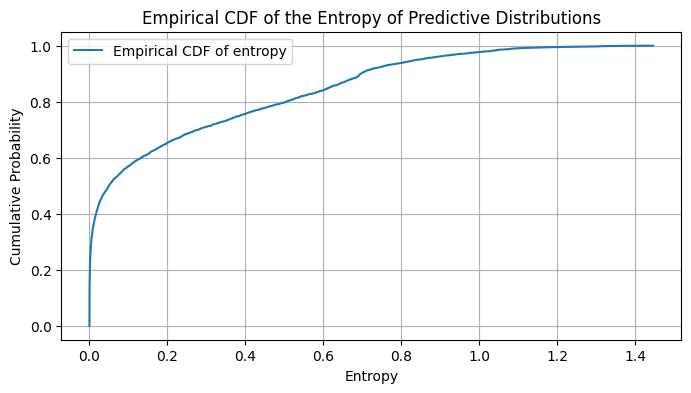

In [7]:
# run baseline
runner = Runner.from_cfg(baseline_cfg)
metrics = runner.test()
baseline_ret = metrics['ecdf_pred_dist/metric']
# Plotting
plt.figure(figsize=(8, 4))
plt.plot(baseline_ret[0], baseline_ret[1], label='Empirical CDF of entropy')
plt.xlabel('Entropy')
plt.ylabel('Cumulative Probability')
plt.title('Empirical CDF of the Entropy of Predictive Distributions')
plt.legend()
plt.grid(True)
plt.show()

06/07 06:18:27 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.9 (main, Apr 17 2024, 14:40:35) [GCC 9.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 3407
    GPU 0: NVIDIA GeForce RTX 3090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.7, V11.7.99
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 1.13.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arc

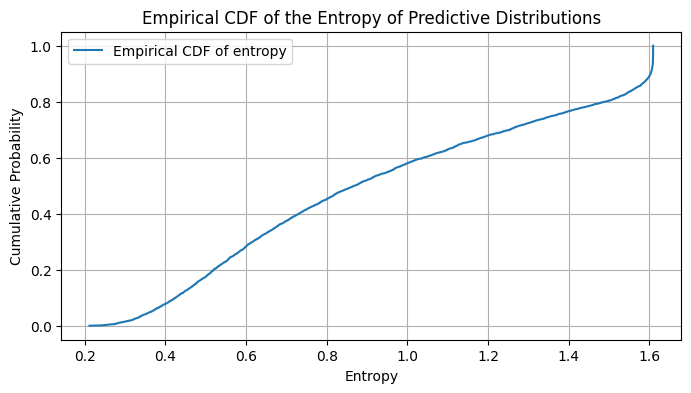

In [8]:
# run EDL
runner = Runner.from_cfg(edl_cfg)
metrics = runner.test()
edl_ret = metrics['ecdf_pred_dist/metric']
# Plotting
plt.figure(figsize=(8, 4))
plt.plot(edl_ret[0], edl_ret[1], label='Empirical CDF of entropy')
plt.xlabel('Entropy')
plt.ylabel('Cumulative Probability')
plt.title('Empirical CDF of the Entropy of Predictive Distributions')
plt.legend()
plt.grid(True)
plt.show()

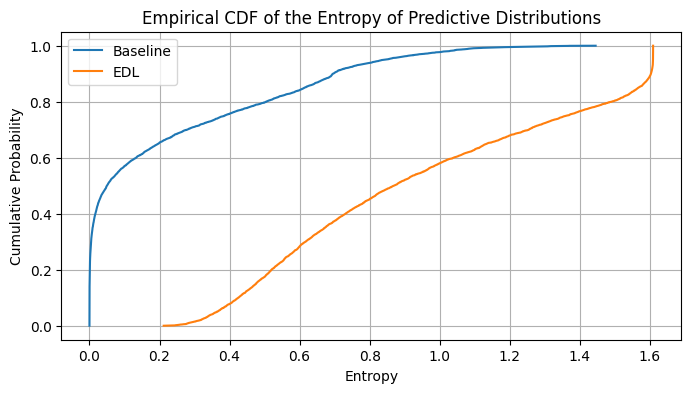

In [9]:
# joint plot
plt.figure(figsize=(8, 4))
plt.plot(baseline_ret[0], baseline_ret[1], label='Baseline')
plt.plot(edl_ret[0], edl_ret[1], label='EDL')
plt.xlabel('Entropy')
plt.ylabel('Cumulative Probability')
plt.title('Empirical CDF of the Entropy of Predictive Distributions')
plt.legend()
plt.grid(True)
plt.show()

Althought the EDL plot seems to be a little worse than the one in the paper (since the line closer to the bottom right is better), this is probably due to the fact that the paper uses a different architecture (LeNet vs ResNet) and training procedure.